In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os

import numpy as np
import matplotlib.pyplot as plt

from NormalizingFlows.src.train import train_backward
from NormalizingFlows.src.scores import log_likelihood
from NormalizingFlows.src.utils import update_device, load_best_model, load_checkpoint_model

from NormalizingFlows.src.flows import *
from NormalizingFlows.src.data.density.bsds300 import BSDS300

In [3]:
def set_visible_devices(*devices: int) -> None:
    '''Utility to set visible Cuda devices.

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.
    '''
    assert all([d >= 0 for d in devices]), f"Not all devices are CUDA devices!"
    os.environ['CUDA_VISIBLE_DEVICES'] = ",".join([str(i) for i in devices])
    

def set_devices(*devices: int):
    '''Utility to set Cuda device(s).

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.

    Returns
    -------
    torch.device or List[torch.device] of currently available CUDA devices.
    '''
    assert len(devices) > 0, f'Device list is empty, no devices set.'
    if len(devices) == 1:
        if devices[0] >= 0:
            set_visible_devices(devices[0])
            return torch.device(0)
        else:
            return torch.device('cpu')

    else:
        set_visible_devices(*devices)
        return [torch.device(i) for i in range(len(devices))]

In [4]:
device = set_devices(3) #torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

In [5]:
dataset = BSDS300()

dim_input = dataset.dim_input
num_trans = 10 #Must be even

dim_hidden = [512, 512]
flows = {}
flow_forward = False


epochs = 8
batch_size = 32
num_exp = 3

In [6]:
f_a = lambda x: torch.abs(torch.arcsinh(x))

two = torch.tensor(2)
def softsaturate(a):
    neg = 2 * (a < 0) * F.softplus(a)
    pos = (a >= 0) * (torch.arcsinh(a) + 2 * torch.log(two))
    return neg + pos

In [7]:
# #ContinuousPiecewiseAffineAffine
# a_param = f_a
# c_param = softsaturate

# name = 'ContinuousPiecewiseAffineAffine exp3'
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_affinecontinuous_trans(num_trans, flow_forward, a_param=a_param, c_param=c_param)
#     affconpiec_coup_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, 'alternate', flow_forward)
#     flows[name] += [affconpiec_coup_alt]
#     flows[name][-1].name = f'{name} {i}'

In [8]:
# #Alt. Lin. Aff.Con
# a_param = f_a
# c_param = softsaturate

# name = 'Alternating Linear_AffineContinuous exp3'
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_alt_linear_affinecontinuous_trans(num_trans, dim_input, flow_forward, a_param=a_param, c_param=c_param)
#     linaffcont_coup_rand = create_flows_with_alt_identity_AR(dim_input, dim_hidden, transformations, 'alternate', flow_forward)
#     flows[name] += [linaffcont_coup_rand]
#     flows[name][-1].name = f'{name} {i}'


In [9]:
#Alt. Lin. Aff.
a_param = softsaturate

name = 'Alternating Linear_Affine exp3_last'
flows[name] = []
for i in range(num_exp):
    transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward,a_param=a_param)
    linaff_coup_rand = create_flows_with_alt_identity_AR(dim_input, dim_hidden, transformations, 'alternate', flow_forward)
    flows[name] += [linaff_coup_rand]
    flows[name][-1].name = f'{name} {i}'

In [10]:
losses = {n: [] for n in flows.keys()}
optimizers = {n: [] for n in flows.keys()}

for flowname in flows.keys():
    for j in range(num_exp):
        # Initialize flow
        flow = flows[flowname][j]
        update_device(device, flow, dataset)

        # Initialize optimizer
        optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-4, weight_decay=0)
        optimizers[flowname].append(optimizer)
        
        # Train and append losses
        losses[flowname].append(
            train_backward(
                flow, 
                dataset.get_training_data(), 
                optimizer, 
                epochs, 
                batch_size, 
                print_n=200, 
                save_checkpoint=True, 
                burn_in=-1
            )
        )

        # Move flow to CPU
        update_device(device_cpu, flow, dataset)

Finished training. Loss for last epoch Alternating Linear_Affine exp3_last 2:   -160.48178


In [11]:
best_flows = {n:[] for n in flows.keys()}
for flowname in flows.keys():
    for i in range(num_exp):
        best_flows[flowname].append(load_best_model(flows[flowname][i]))

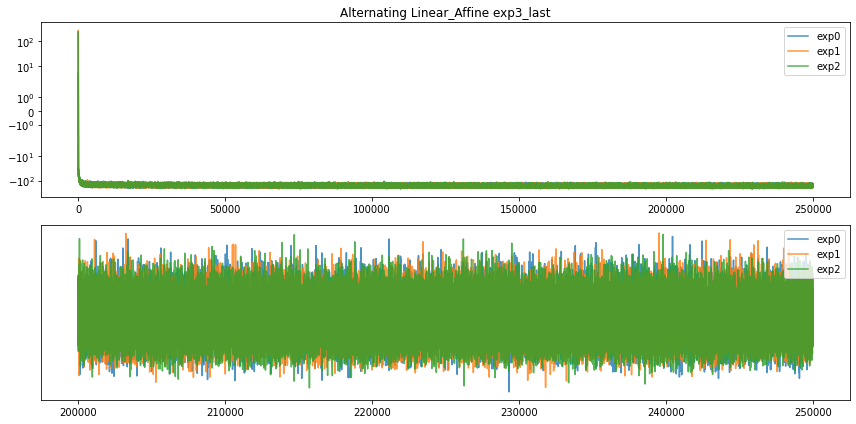

In [27]:
log_scale = True
from_iter = 200000

fig, ax = plt.subplots(2, len(flows), figsize=(12,6))
for j, flowname in enumerate(flows.keys()):
    for i in range(num_exp):
        ax[0].plot(losses[flowname][i], label=f'exp{i}', alpha=0.8)
        ax[0].set_title(f'{flowname}')
        if log_scale:
            ax[0].set_yscale('symlog')
        ax[0].legend()

log_scale = True
for j, flowname in enumerate(flows.keys()):
    for i in range(num_exp):
        x = np.arange(len(losses[flowname][i]))
        ax[1].plot(x[from_iter:], losses[flowname][i][from_iter:], label=f'exp{i}', alpha=0.8)
        if log_scale:
            ax[1].set_yscale('symlog')
        ax[1].legend()
    
plt.tight_layout()

In [26]:
flow_lh_results = {
    'train': {n:[] for n in flows}, 
    'test': {n:[] for n in flows}, 
    'sample': {n:[] for n in flows},
}
cur_res = 'train'

print('Results based on training data:' + '\n')

# Function for CI
def mean_confidence_interval(data, confidence=0.95):
    import scipy.stats
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h
 

train_data = dataset.get_training_data()
for flow in best_flows:
    for i in range(num_exp):
        # Fails due to large number of training data?
        # Bootstrap subsample instead
        random_indices = np.random.choice(np.arange(len(train_data)), 500000)
        log_lik, mean = log_likelihood(train_data[random_indices], best_flows[flow][i])
        flow_lh_results[cur_res][flow].append(mean[0])
        print("Mean loglikelihood for {}: {}".format(f'{flow} {i}', mean))
        print()
    
    m, h = mean_confidence_interval(flow_lh_results[cur_res][flow])
    print('-'*75)
    print(f'{flow} -- Mean LogLH Bootstrap: {m:7.4f} ± {h:7.4f}')
    print('-'*75)
    print()
    

Results based on training data:

Mean loglikelihood for Alternating Linear_Affine exp3_last 0: [160.79547]

Mean loglikelihood for Alternating Linear_Affine exp3_last 1: [160.47902]

Mean loglikelihood for Alternating Linear_Affine exp3_last 2: [160.89197]

---------------------------------------------------------------------------
Alternating Linear_Affine exp3_last -- Mean LogLH Bootstrap: 160.7222 ±  0.5366
---------------------------------------------------------------------------



In [21]:
print('Results based on test data' + '\n')
cur_res = 'test' 

test_data = dataset.get_test_data()
for flow in best_flows:
    for i in range(num_exp):
        log_lik, mean = log_likelihood(test_data, best_flows[flow][i])
        flow_lh_results[cur_res][flow].append(mean[0])
        print("Mean loglikelihood for {}: {}".format(f'{flow} {i}', mean))
        print()
    
    m, h = mean_confidence_interval(flow_lh_results[cur_res][flow])
    print('-'*75)
    print(f'{flow} -- Mean LogLH Bootstrap: {m:7.4f} ± {h:7.4f}')
    print('-'*75)
    print()
    

# for flow in best_flows:
#     log_lik, mean = log_likelihood(test_data, flow)
#     print("Mean loglikelihood for {}: {}".format(str(flow), mean))
#     print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    

# print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on test data

Mean loglikelihood for Alternating Linear_Affine exp3_last 0: [151.67253]

Mean loglikelihood for Alternating Linear_Affine exp3_last 1: [151.33246]

Mean loglikelihood for Alternating Linear_Affine exp3_last 2: [151.62585]

---------------------------------------------------------------------------
Alternating Linear_Affine exp3_last -- Mean LogLH Bootstrap: 151.5620 ±  0.1463
---------------------------------------------------------------------------

